In [1]:
# !pip install pystan
# !pip install fbprophet
# !pip install plotly
# !pip install ipywidgets
"""
ref: prophet docs
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import json
from fbprophet.serialize import model_to_json, model_from_json


# State %-production share

# MAHARASHTRA 29.59
# MADHYA PRADESH 15.16
# KARNATAKA 13.64
# GUJARAT 6.42
# BIHAR 6.25
# RAJASTHAN 4.80
# ANDHRA PRADESH 5.02
# source: http://agricoop.gov.in/sites/default/files/Monthly%20Report%20on%20Onion%20for%20May%2C%202018.pdf



$$y(t)=g(t)+s(t)+h(t)+\epsilon _t$$
$$g(t)=\frac{C}{1+}$$
$$s(t)=\sum_{n=1}^{N}\bigg(a_n \cos\Big(\frac{2\pi nt}{P}\Big) + b_n \sin\Big(\frac{2\pi nt}{P}\Big)\bigg)$$
$$$$

```

In [2]:
df = pd.read_csv('full_onion_data.csv')
df = df.drop(['Unnamed: 0', 'DISTRICT', 'MARKET', 'COMMODITY', 'VARIETY', 'GRADE',
       'MIN', 'MAX'], axis= 1)
df['ds'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%d %b %Y"))
df['y'] = df['MODAL'].apply(lambda x: int(x))
df = df.sort_values(by=['ds'])

In [3]:
df.dtypes

MODAL           float64
DATE             object
ds       datetime64[ns]
y                 int64
dtype: object

In [4]:
df.head()

MODAL         DATE         ds     y
2681  1250.0  01 Jan 2010 2010-01-01  1250
2680  1375.0  02 Jan 2010 2010-01-02  1375
2679  1150.0  04 Jan 2010 2010-01-04  1150
2678  1125.0  05 Jan 2010 2010-01-05  1125
2677  1150.0  07 Jan 2010 2010-01-07  1150

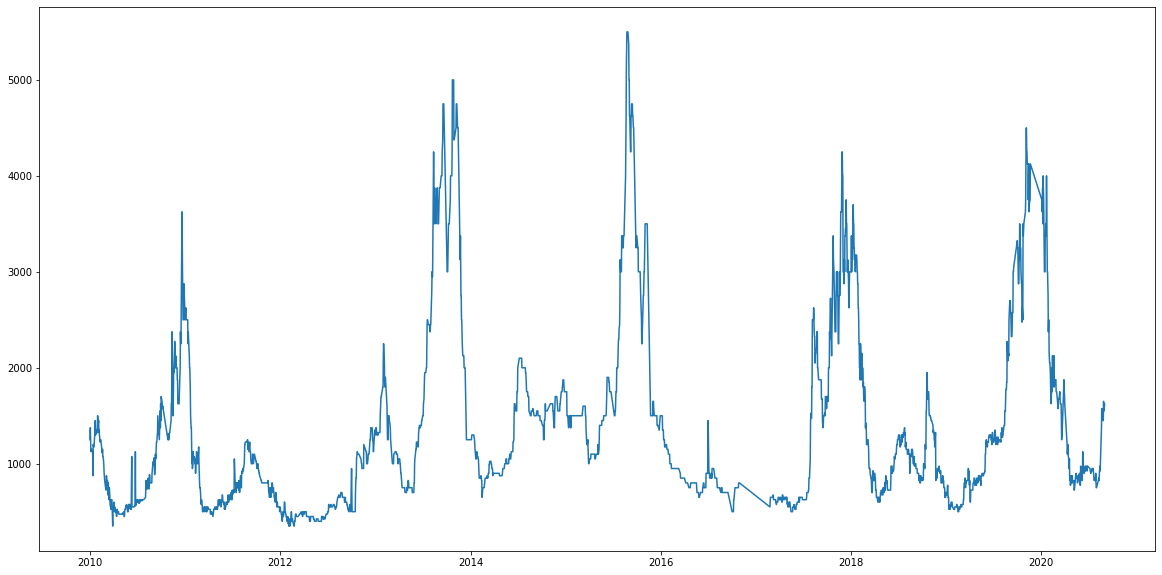

In [5]:
plt.figure(figsize=(20,10))
plt.plot(df['ds'], df['y'])
plt.show()

In [6]:
m = Prophet()
# Prophet.add_country_holidays(m, "India")
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
future = m.make_future_dataframe(periods=7)
future.tail()

ds
2684 2020-09-03
2685 2020-09-04
2686 2020-09-05
2687 2020-09-06
2688 2020-09-07

In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds         yhat   yhat_lower   yhat_upper
2684 2020-09-03  2473.862178  1600.191634  3295.159617
2685 2020-09-04  2474.328759  1614.612334  3305.783132
2686 2020-09-05  2460.054047  1582.232116  3366.375463
2687 2020-09-06  2515.186900  1637.421910  3289.892888
2688 2020-09-07  2486.313917  1614.218703  3285.703396

In [9]:
# with open('serialized_model.json', 'w') as fout:
#     json.dump(model_to_json(m), fout)  # Save model

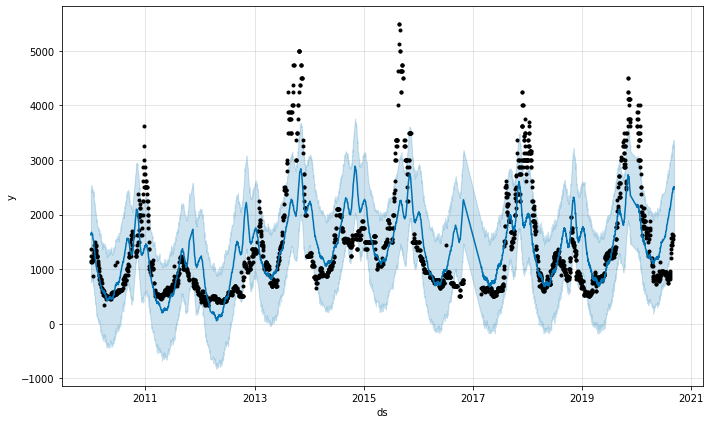

In [10]:
fig1 = m.plot(forecast)

In [39]:
f2 = forecast.copy()
f2['orj'] = pd.Series(df['y'].to_numpy())
def tst(C1, C2, C, D):

    for i in range(1, len(forecast)//7-7):
        cnt = 0
        upp = 0
        low = 0
        for j in range((i-1)*7, (i)*7):
            if abs(forecast['yhat_lower'][j]-forecast['yhat_upper'][j])*C1 < abs(forecast['yhat'][j]-df['y'][len(df)-1-j]):
                cnt += 1
            if forecast['yhat'][j]-df['y'][len(df)-1-j] < 0:
                upp += 1
            else: low += 1
        if cnt >= C2:
            for j in range((i)*7, (i+1)*7):
                # current_yhat, prev_yhat_prophet, prev_yhat_f2,
                # prev_data
                # yhat_lower_curr, yhat_upper_curr
                # yhat_lower_prev, yhat_upper_prev
                # cnt
                
                # forecast['yhat_lower'][j], forecast['yhat_upper'][j],
                # forecast['yhat_lower'][j-7], forecast['yhat_upper'][j-7],

                f2['yhat'][j] = C[0] * forecast['yhat'][j] + C[1] * forecast['yhat'][j-7] + C[2] * f2['yhat'][j-7] + C[3] * df['y'][len(df)-1-j+7] 
                if upp > low:
                    f2['yhat'][j] += D[0] * forecast['yhat_upper'][j] + D[1] * forecast['yhat_upper'][j-7]
                else:
                    f2['yhat'][j] += D[0] * forecast['yhat_lower'][j] + D[1] * forecast['yhat_lower'][j-7]
    
    f2['sqe'] = (f2['yhat'] - f2['orj'])**2
    return (f2['sqe'].sum()/len(f2['sqe']-7))**(1/2)


In [40]:
tst(0.25,5, [0.3, 0.15, 0.1, 0.4], [0.2, 0])

<ipython-input-39-0ed9a1def6f3>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-39-0ed9a1def6f3>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-39-0ed9a1def6f3>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



443.02672873865254

In [37]:
plot_plotly(m, f2)

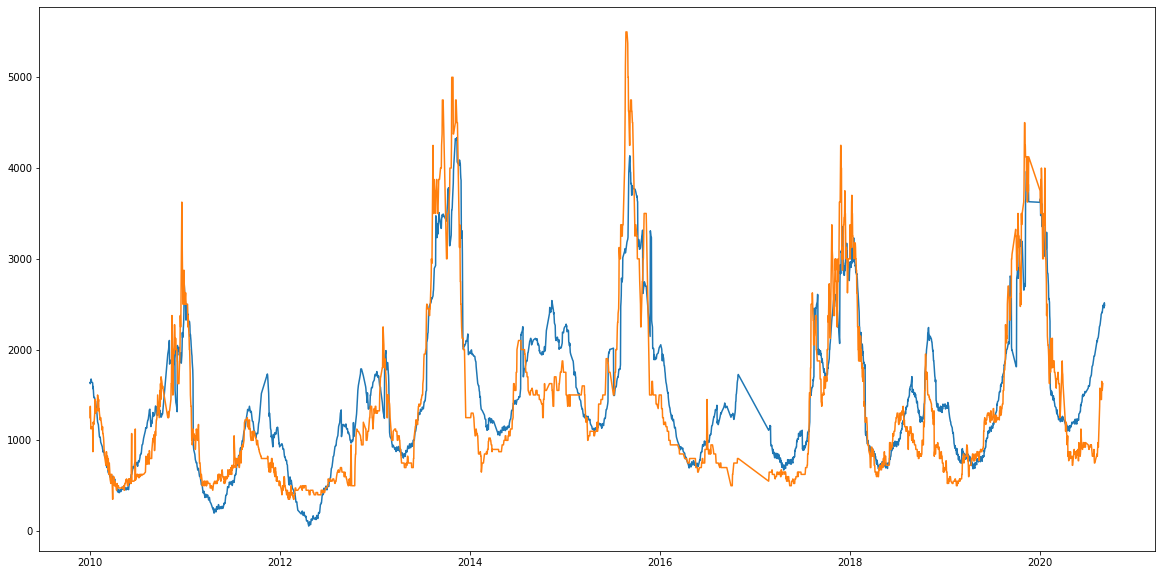

In [41]:
plt.figure(figsize=(20,10))
plt.plot(f2['ds'], f2['yhat'])
plt.plot(df['ds'], df['y'])
# plt.plot(dfl_t[i]['ds'], dfl_t[i]['y'])
plt.show()

In [75]:
f2['orj'] = pd.Series(df['y'].to_numpy())

<AxesSubplot:>

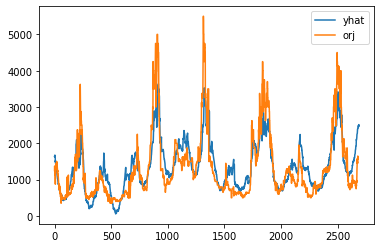

In [76]:
f2[['yhat', 'orj']].plot()

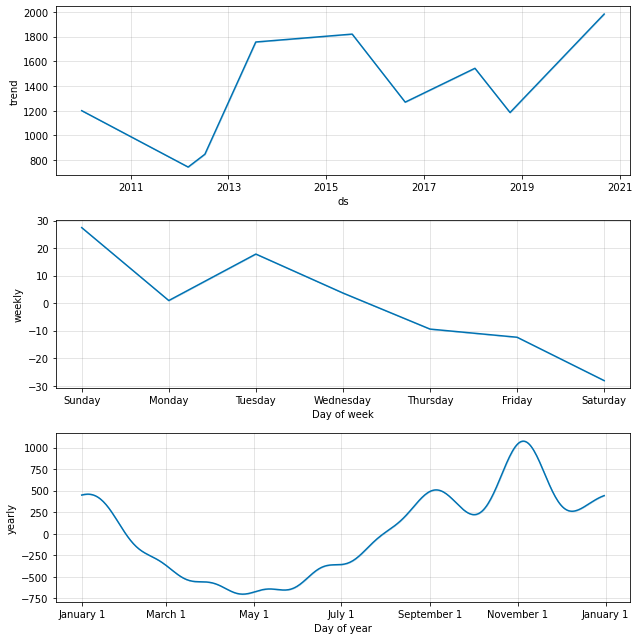

In [14]:
fig2 = m.plot_components(f2)

In [15]:
plot_plotly(m, f2)

In [16]:
plot_components_plotly(m, f2)